In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/elizabethrogers/Desktop/powersystemspublichealth


In [2]:
import os

# import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so


# Create a list of the New England state FIPS codes
# ne_fips = ['09', '23', '25', '33', '44', '50']

In [3]:
# List of New England state FIPS codes
state_abbrv_to_FIPS = {
    "CT": "09",
    "ME": "23",
    "MA": "25",
    "NH": "33",
    "RI": "44",
    "VT": "50",
    "NY": "36"
}

NE_state_abbrv_to_state = {
    'CT': 'Connecticut',
    'ME': 'Maine',
    'MA': 'Massachusetts',
    'NH': 'New Hampshire',
    'RI': 'Rhode Island',
    'VT': 'Vermont',
    'NY': 'New York'
}

NE_state_to_state_abbrv = {v: k for k, v in NE_state_abbrv_to_state.items()}

equity_data_dir = 'equitydatasets'
NE_outcomes_dir = 'NewEnglandSpecificOutcomes'

# data sets
population = pd.read_csv(os.path.join(equity_data_dir, "PopulationEstimates.csv"))
poverty = pd.read_csv(os.path.join(equity_data_dir, "Poverty2023.csv"))
# includes income data, from USDA
unemployment = pd.read_csv(os.path.join(equity_data_dir, "UnemploymentAndIncome2023.csv"))
#ACS income data that chris sent in the discord
income_complete = pd.read_csv(os.path.join(equity_data_dir, "ACSPopulation.csv"),
    skiprows=(1))

pop_complete = pd.read_csv(os.path.join(equity_data_dir, "ACSDP5Y2021.DP05-Data.csv"),
    skiprows=(1)) 


# cobra outcomes
highhealth = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116highhealthGeneratorOutcome.csv"),
    skiprows=(1,3110))
lowhealth = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116lowhealthGeneratorOutcome.csv"),
    skiprows=(1,3110))

carbon = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116CarbonEmissionsOutcome.csv"),
    skiprows=(1,3110))
mixedhigh = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116mixhighGeneratorOutcome.csv"),
    skiprows=(1,3110))
mixedlow = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116mixlowGeneratorOutcome.csv"),
    skiprows=(1,3110))
original = pd.read_csv(os.path.join(NE_outcomes_dir, "Fall116OriginalCostGeneratorOutcome.csv"),
    skiprows=(1,3110))

In [48]:
income_complete
NE_state_to_state_abbrv

{'Connecticut': 'CT',
 'Maine': 'ME',
 'Massachusetts': 'MA',
 'New Hampshire': 'NH',
 'Rhode Island': 'RI',
 'Vermont': 'VT',
 'New York': 'NY'}

## High Health (Total Health Benefits - high estimate)

In [24]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(highhealth.dtypes)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pop_complete.dtypes)

Geography                                                                                                                                                                           object
Geographic Area Name                                                                                                                                                                object
Estimate!!SEX AND AGE!!Total population                                                                                                                                              int64
Margin of Error!!SEX AND AGE!!Total population                                                                                                                                      object
Estimate!!SEX AND AGE!!Total population!!Male                                                                                                                                        int64
Margin of Error!!SEX AND AGE!!Total population!!Male             

In [4]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]
NE_highhealth = highhealth.loc[
    highhealth['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_highhealth = NE_highhealth.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits (low)',
})

NE_highhealth['State'] = NE_highhealth['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_highhealth = NE_highhealth.set_index(['State', 'County']).sort_index()

In [21]:
NE_highhealth

Health Benefits (high)  Health Benefits (low)
State County                                                   
CT    Fairfield                -0.003109              -0.001507
      Hartford                  0.016555               0.007965
      Litchfield                0.001718               0.000857
      Middlesex                 0.000602               0.000266
      New Haven                -0.001085              -0.000624
...                                  ...                    ...
VT    Orleans                  -0.000337              -0.000165
      Rutland                   0.001299               0.000659
      Washington                0.000325               0.000166
      Windham                   0.001273               0.000621
      Windsor                   0.001263               0.000653

[129 rows x 2 columns]

# Population

In [5]:
NE_population_mask = population['State'].isin(NE_state_abbrv_to_state.keys())

NE_population = population.loc[
    NE_population_mask & (population['Attribute'] == 'POP_ESTIMATE_2021'),
    ['State', 'Area_Name', 'Value']
]

NE_population = NE_population.rename(columns={'Area_Name': 'County', 'Value': 'Population'})

NE_population = NE_population.loc[NE_population['County'].str.contains('County')]
NE_population['County'] = NE_population['County'].str.replace(' County', '', regex=False)

assert (NE_population['Population'] % 1.).max() == 0.
NE_population['Population'] = NE_population['Population'].astype(int)
NE_population = NE_population.set_index(['State', 'County']).sort_index()['Population']

In [6]:
NE_population

State  County    
MA     Barnstable    232315
       Berkshire     128376
       Bristol       579756
       Dukes          21127
       Essex         807360
                      ...  
VT     Orleans        27591
       Rutland        60728
       Washington     60033
       Windham        46150
       Windsor        58350
Name: Population, Length: 121, dtype: int64

Redo for dataset with a more complete population count for 2021

In [6]:
# Estimate!!SEX AND AGE!!Total population
# Extract the county and state into new columns
pop_complete[['County', 'State']] = income_complete["Geographic Area Name"].str.split(r', ', expand=True)

# Remove the original column and rearrange the order
pop_complete = pop_complete.drop("Geographic Area Name", axis=1)
pop_complete = pop_complete[['County', 'State', 'Estimate!!SEX AND AGE!!Total population']]

pop_complete

,County,State,Estimate!!SEX AND AGE!!Total population
0,Autauga County,Alabama,58239
1,Baldwin County,Alabama,227131
2,Barbour County,Alabama,25259
3,Bibb County,Alabama,22412
4,Blount County,Alabama,58884
...,...,...,...
3216,Vega Baja Municipio,Puerto Rico,54544
3217,Vieques Municipio,Puerto Rico,8317
3218,Villalba Municipio,Puerto Rico,22341
3219,Yabucoa Municipio,Puerto Rico,31047


In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pop_complete.dtypes)

County                                     object
State                                      object
Estimate!!SEX AND AGE!!Total population     int64
dtype: object

In [7]:
NE_pop_comp_mask = pop_complete['State'].isin(NE_state_to_state_abbrv.keys())


# stands for income complete - trying to see if this includes more data for areas of interest
NE_pop_comp = pop_complete.loc[
    NE_pop_comp_mask ,
    ['State', 'County', 'Estimate!!SEX AND AGE!!Total population']
]

NE_pop_comp = NE_pop_comp.rename(columns={'Estimate!!SEX AND AGE!!Total population': 'Population'})

# NE_income_comp= NE_income_comp.loc[NE_income_comp['County'].str.contains('County')]
# # NE_income_comp['County'] = NE_income_comp['County'].str.replace(' County, ..', '', regex=True)
NE_pop_comp['County'] = NE_pop_comp['County'].replace(' County', '', regex=True)

# assert (NE_pop_comp['Populaiton'] % 1.).max() == 0.
NE_pop_comp['Population'] = NE_pop_comp['Population'].astype(int)
# NE_pop_comp['County'] = NE_pop_comp['County'].astype(str)
# NE_pop_comp['State'] = NE_pop_comp['State'].astype(str)



NE_pop_comp['State'] = NE_pop_comp['State'].map(lambda x: NE_state_to_state_abbrv[x])
NE_pop_comp = NE_pop_comp.set_index(['State', 'County']).sort_index()['Population']


In [11]:
NE_pop_comp
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(NE_pop_comp.dtypes)

dtype('int64')

# Income

original dataset with multiple data on unimployment + income

In [12]:
NE_income_mask = unemployment['State'].isin(NE_state_abbrv_to_state.keys())

NE_income = unemployment.loc[
    NE_income_mask & (unemployment['Attribute'] == 'Median_Household_Income_2022'),
    ['State', 'Area_Name', 'Value']
]

NE_income

NE_income = NE_income.rename(columns={'Area_Name': 'County', 'Value': 'Income'})

NE_income = NE_income.loc[NE_income['County'].str.contains('County')]
NE_income['County'] = NE_income['County'].str.replace(' County, ..', '', regex=True)

assert (NE_income['Income'] % 1.).max() == 0.
NE_income['Income'] = NE_income['Income'].astype(int)
NE_income = NE_income.set_index(['State', 'County']).sort_index()['Income']

In [10]:
NE_income

State  County    
MA     Barnstable    89774
       Berkshire     71102
       Bristol       80702
       Dukes         89136
       Essex         92118
                     ...  
VT     Orleans       56818
       Rutland       61290
       Washington    77432
       Windham       61976
       Windsor       74244
Name: Income, Length: 121, dtype: int64

Dataset that is hopefully more complete, chris shared in the discord channel

In [13]:
# Extract the county and state into new columns
income_complete[['County', 'State']] = income_complete["Geographic Area Name"].str.split(r', ', expand=True)

# Remove the original column and rearrange the order
income_complete = income_complete.drop("Geographic Area Name", axis=1)
income_complete = income_complete[['County', 'State', 'Estimate!!Households!!Median income (dollars)']]

income_complete

,County,State,Estimate!!Households!!Median income (dollars)
0,Autauga County,Alabama,62660
1,Baldwin County,Alabama,64346
2,Barbour County,Alabama,36422
3,Bibb County,Alabama,54277
4,Blount County,Alabama,52830
...,...,...,...
3216,Vega Baja Municipio,Puerto Rico,21507
3217,Vieques Municipio,Puerto Rico,14942
3218,Villalba Municipio,Puerto Rico,20722
3219,Yabucoa Municipio,Puerto Rico,17267


In [14]:
NE_income_comp_mask = income_complete['State'].isin(NE_state_to_state_abbrv.keys())


# stands for income complete - trying to see if this includes more data for areas of interest
NE_income_comp = income_complete.loc[
    NE_income_comp_mask,
    ['State', 'County', 'Estimate!!Households!!Median income (dollars)']
]

NE_income_comp = NE_income_comp.rename(columns={'Estimate!!Households!!Median income (dollars)': 'Income'})

# NE_income_comp= NE_income_comp.loc[NE_income_comp['County'].str.contains('County')]
# # NE_income_comp['County'] = NE_income_comp['County'].str.replace(' County, ..', '', regex=True)
NE_income_comp['County'] = NE_income_comp['County'].replace(' County', '', regex=True)

# # # assert (NE_income_comp['Income'] % 1.).max() == 0.
NE_income_comp['Income'] = NE_income_comp['Income'].astype(int)



NE_income_comp['State'] = NE_income_comp['State'].map(lambda x: NE_state_to_state_abbrv[x])
NE_income_comp = NE_income_comp.set_index(['State', 'County']).sort_index()['Income']



In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(NE_income_comp.dtypes)
# NE_income_comp

dtype('int64')

# Join

In [15]:
# TODO: use outer first, then check for NaNs
# Fix earlier code until there's no NaNs
# Currently, Connecticut has NaNs in population and income, because it only has 2020 population listed, not 2021
# Notes: St. Lawrence has a period on only some of the data sets
outer = NE_highhealth.join([NE_pop_comp, NE_income_comp], how='outer')
outer[outer.isna().any(axis=1)]

,,Health Benefits (high),Health Benefits (low),Population,Income
State,County,,,,


In [22]:
inner = NE_highhealth.join([NE_pop_comp, NE_income_comp], how='inner').reset_index()



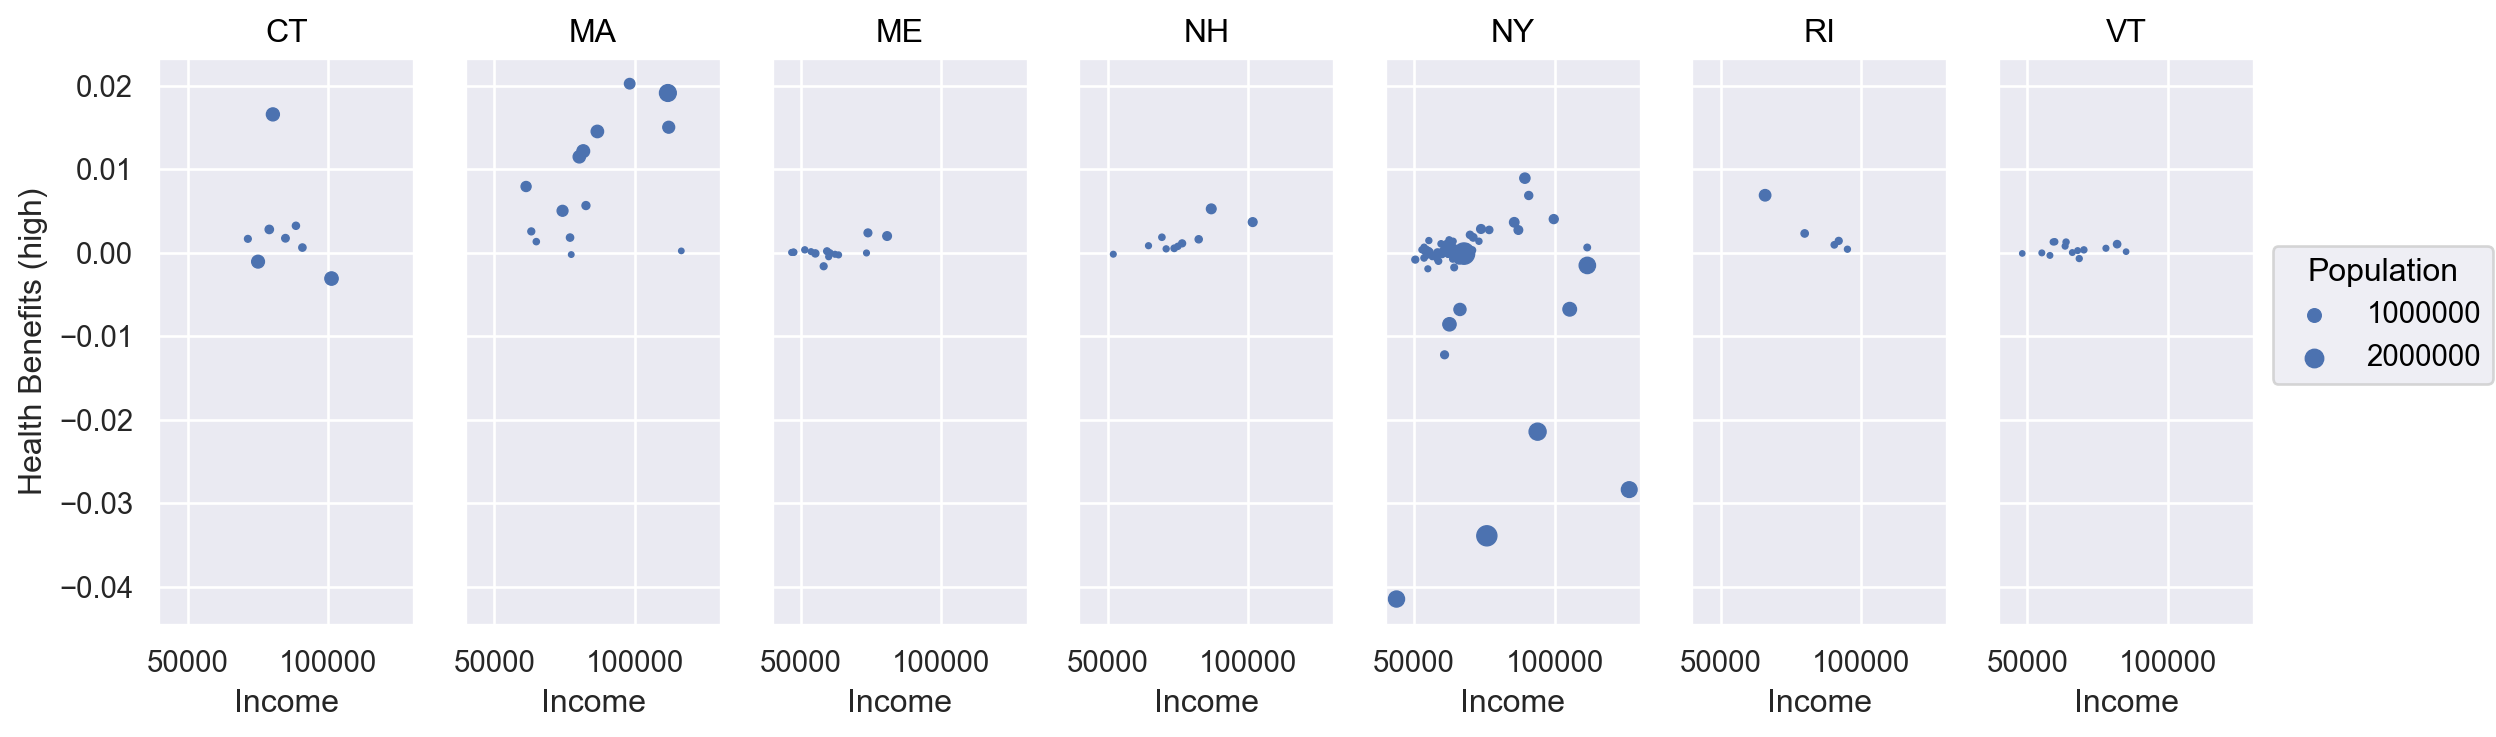

In [23]:
(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)